In [86]:
import pandas as pd

# Load the dataset
file_path = 'diabetes_dataset.csv'
diabetes_data = pd.read_csv(file_path)
# Display the first few rows of the dataset to examine its structure
diabetes_data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [87]:
import numpy as np

# Replace zeros with NaN in columns where zero does not make sense
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_data[columns_to_replace] = diabetes_data[columns_to_replace].replace(0, np.nan)

# Fill missing values with the mean of each column
diabetes_data.fillna(diabetes_data.mean(), inplace=True)


In [88]:
# Check for any remaining missing values
diabetes_data.isnull().sum()


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [89]:
# Identify the target variable
target = 'Outcome'

# Identify predictor variables
predictors = list(diabetes_data.columns.drop(target))


In [90]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    diabetes_data[predictors], diabetes_data[target], test_size=0.3, random_state=42)


In [91]:
import statsmodels.api as sm

def stepwise_selection(X, y, initial_list=[], threshold_in=0.1, threshold_out = 0.1):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True

        # backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=0)
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
        if not changed:
            break
    return included

# Perform stepwise selection
selected_features = stepwise_selection(X_train, y_train)

# Build the final model with selected features
final_logit_model = sm.Logit(y_train, sm.add_constant(X_train[selected_features])).fit()
final_logit_model.summary()


Optimization terminated successfully.
         Current function value: 0.451627
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  537
Model:                          Logit   Df Residuals:                      533
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                  0.3025
Time:                        04:25:41   Log-Likelihood:                -242.52
converged:                       True   LL-Null:                       -347.71
Covariance Type:            nonrobust   LLR p-value:                 2.420e-45
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4668      0.935    -11.192      0.000     -12.300      -8.634
Glucose        0.0391      0.005      8.665      0.000       0.030       0.048
BMI            0.1091      0.018      6.042      0.000       0.074       0.145
Age            0.0393      0.010      4.065      0.000       0.020       0.058
==============================================================================
"""

In [92]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix)

# Predict on the test set
y_pred = final_logit_model.predict(sm.add_constant(X_test[selected_features]))
y_pred_class = (y_pred > 0.5).astype(int)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)


Accuracy: 0.7316017316017316
Precision: 0.618421052631579
Recall: 0.5875
F1 Score: 0.6025641025641025
ROC-AUC: 0.7769039735099338


In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=4, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best cross-validation score: 0.75


In [94]:
# Train the final model with the best parameters
best_dt = grid_search.best_estimator_

# Fit the model
best_dt.fit(X_train, y_train)


DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20,
                       random_state=42)

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predict on the test set
y_pred_dt = best_dt.predict(X_test)

# Calculate performance metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, best_dt.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy_dt)
print("Precision:", precision_dt)
print("Recall:", recall_dt)
print("F1 Score:", f1_dt)
print("ROC-AUC:", roc_auc_dt)


Accuracy: 0.7272727272727273
Precision: 0.6197183098591549
Recall: 0.55
F1 Score: 0.5827814569536424
ROC-AUC: 0.7812499999999999


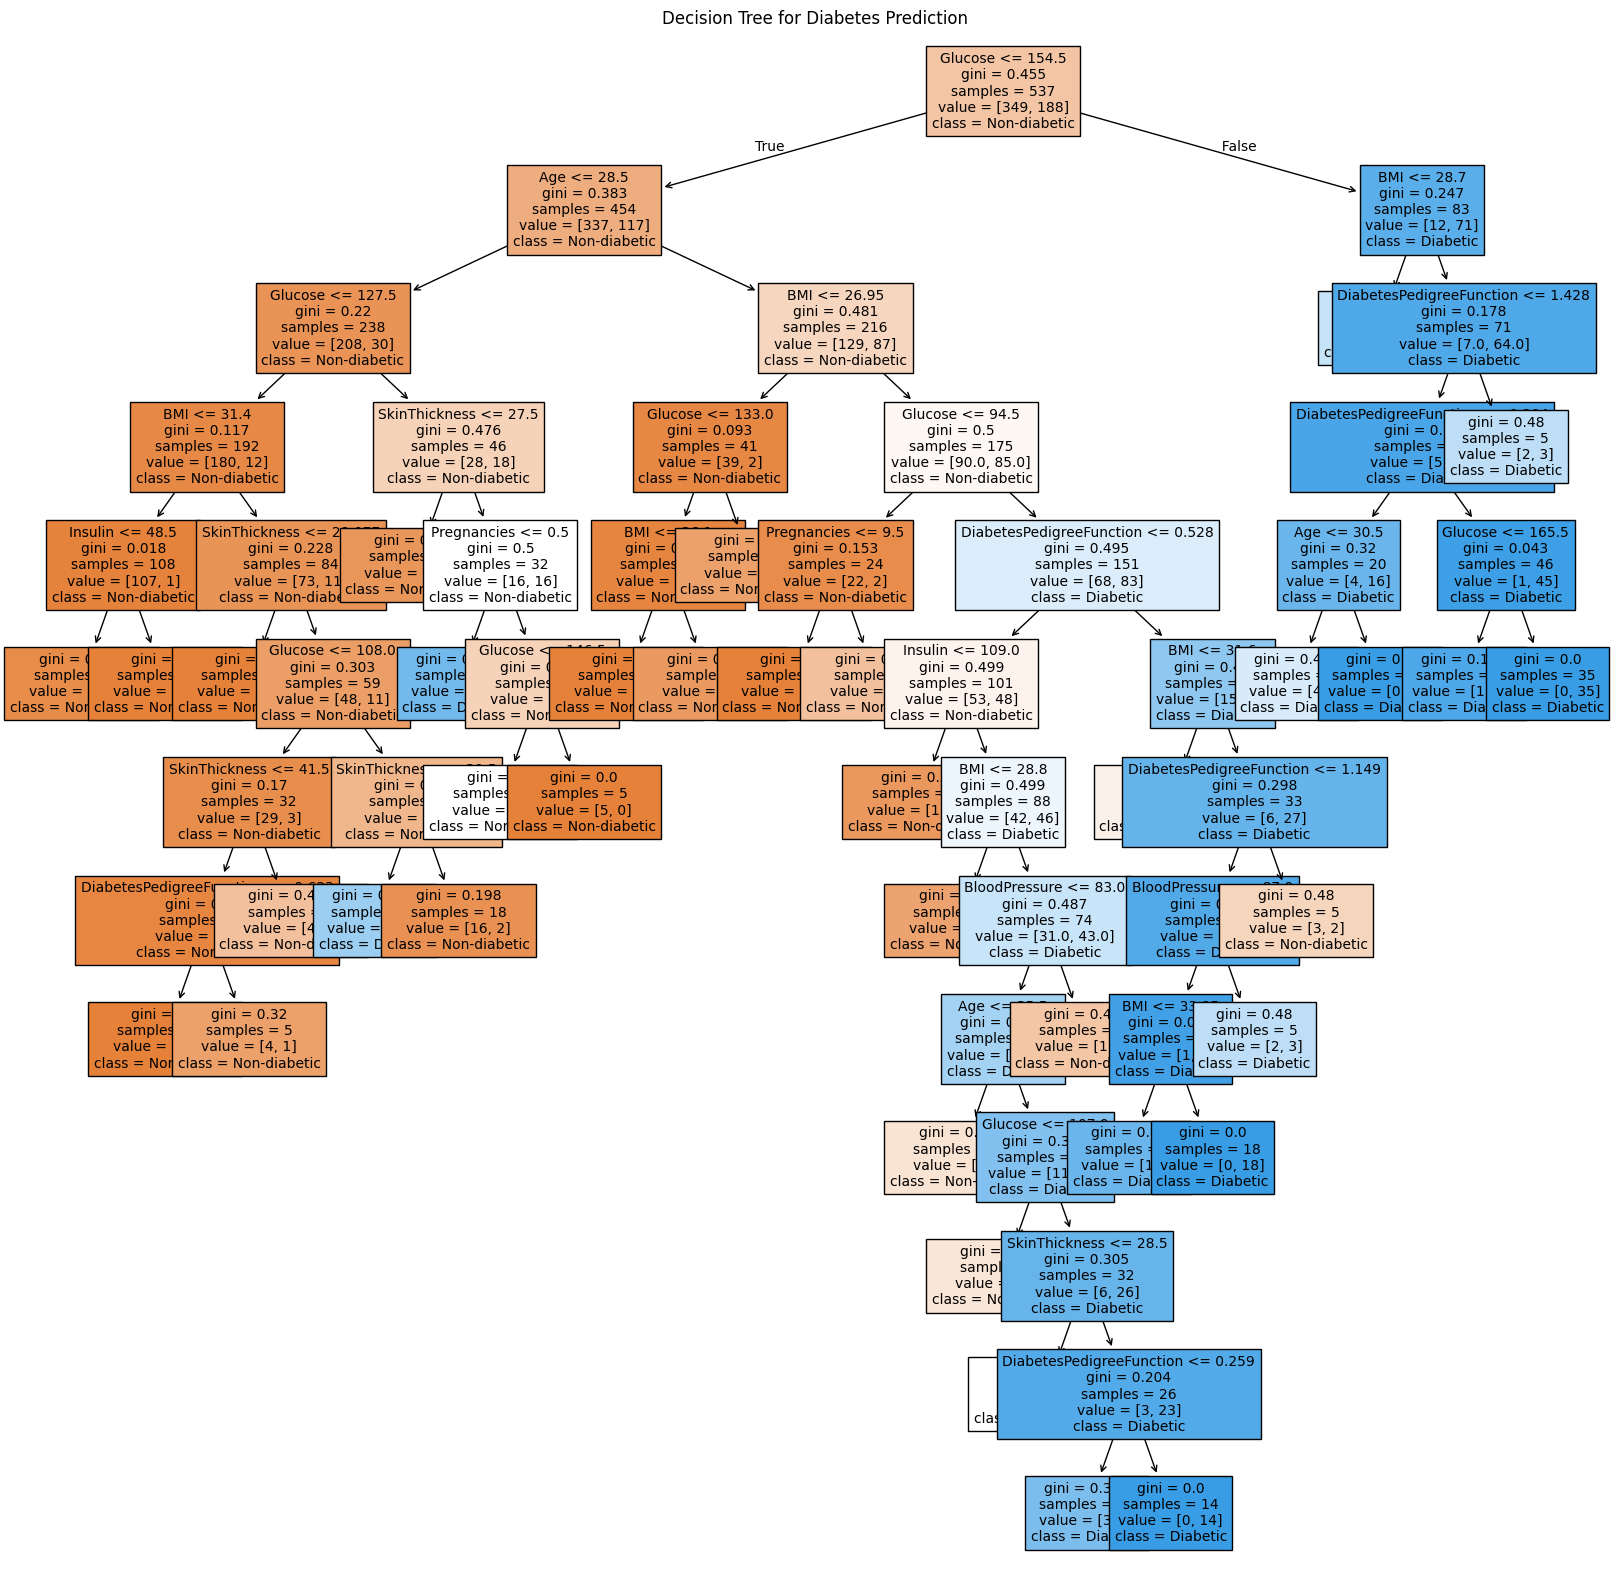

In [96]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the decision tree
plt.figure(figsize=(20,20))
plot_tree(best_dt, filled=True, feature_names=predictors, class_names=['Non-diabetic', 'Diabetic'], fontsize=10)
plt.title("Decision Tree for Diabetes Prediction")
plt.show()


In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Convert X_train with selected features for logistic regression
X_train_logit = sm.add_constant(X_train[selected_features])
X_test_logit = sm.add_constant(X_test[selected_features])

# Initialize the Logistic Regression model
logit_cv_model = LogisticRegression(max_iter=1000)

# Fit the model with the training data
logit_cv_model.fit(X_train_logit, y_train)

# Perform 4-fold cross-validation
cv_scores = cross_val_score(logit_cv_model, X_train_logit, y_train, cv=4)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score: {:.2f}".format(cv_scores.mean()))


Cross-validation scores: [0.82962963 0.71641791 0.79104478 0.78358209]
Mean cross-validation score: 0.78


In [98]:
# Function to evaluate both models on training set vs test set to check for overfitting
def evaluate_model_performance(model, X_train, y_train, X_test, y_test, model_name="Model"):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracy for train and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"{model_name} - Training Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

# Evaluate Logistic Regression
evaluate_model_performance(logit_cv_model, X_train_logit, y_train, X_test_logit, y_test, "Logistic Regression")

# Evaluate Decision Tree
evaluate_model_performance(best_dt, X_train, y_train, X_test, y_test, "Decision Tree")


Logistic Regression - Training Accuracy: 0.78, Test Accuracy: 0.73
Decision Tree - Training Accuracy: 0.85, Test Accuracy: 0.73


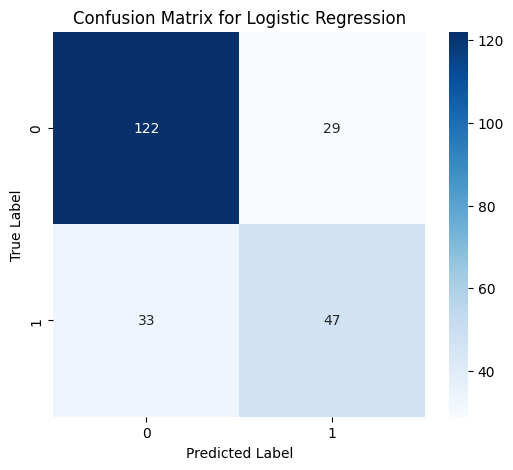

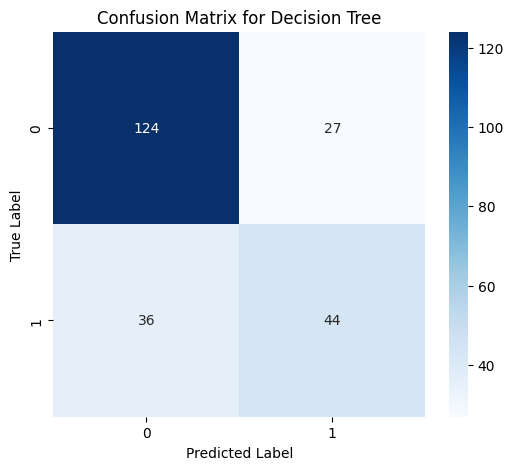

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Confusion matrices
cm_logit = confusion_matrix(y_test, logit_cv_model.predict(X_test_logit))
plot_confusion_matrix(cm_logit, "Logistic Regression")

cm_dt = confusion_matrix(y_test, best_dt.predict(X_test))
plot_confusion_matrix(cm_dt, "Decision Tree")


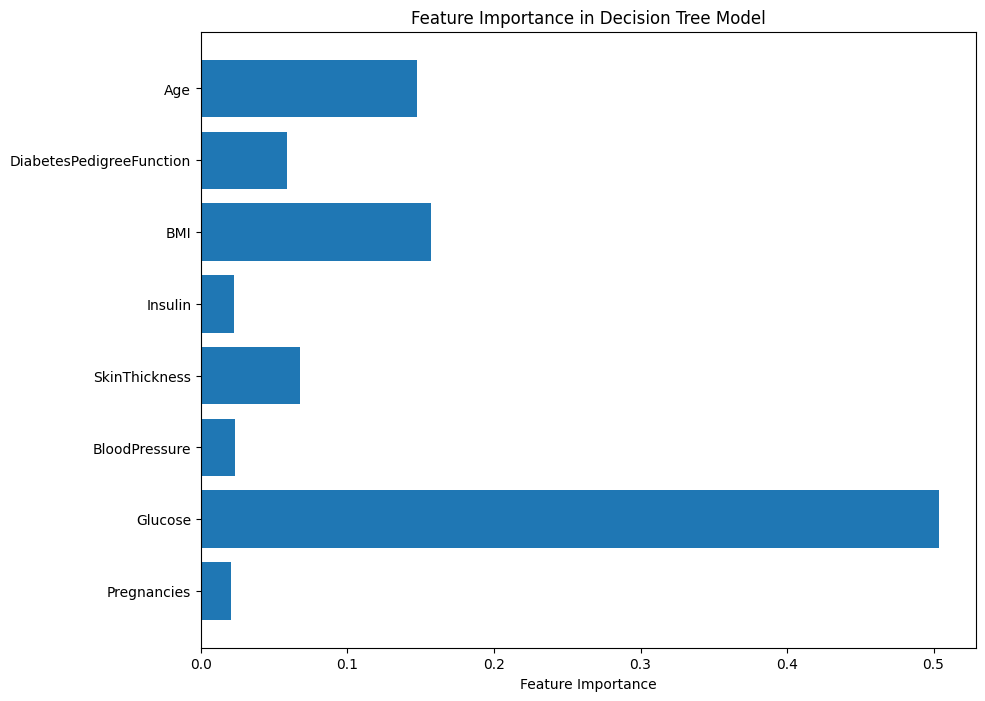

In [100]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importances = best_dt.feature_importances_

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), X_train.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.show()


In [101]:
# Display the p-values of the selected predictors
p_values = final_logit_model.pvalues
print("P-values of the selected predictors in the logistic regression model:")
print(p_values)


P-values of the selected predictors in the logistic regression model:
const      4.450937e-29
Glucose    4.521437e-18
BMI        1.520968e-09
Age        4.811592e-05
dtype: float64


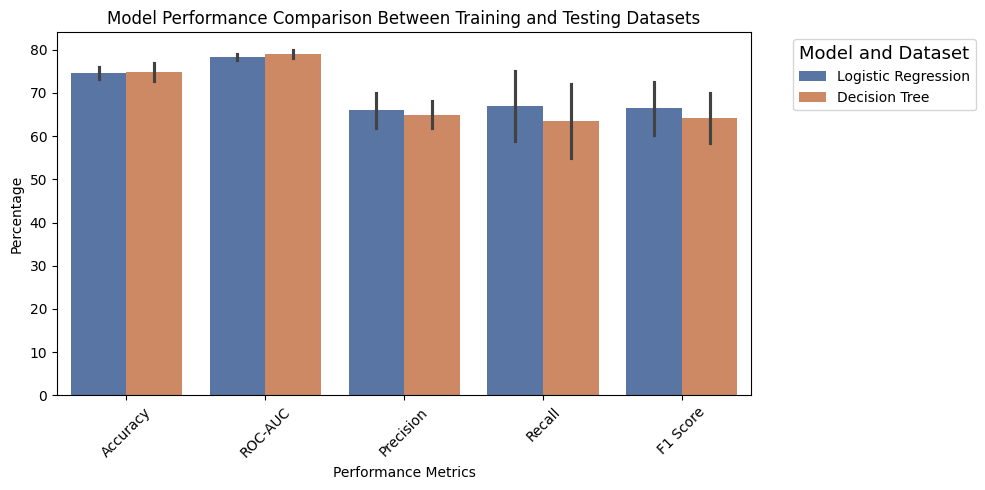

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data = {
    "Model": ["Logistic Regression", "Decision Tree", "Logistic Regression", "Decision Tree"],
    "Dataset": ["Training", "Training", "Testing", "Testing"],
    "Accuracy": [76, 77, 73.16, 72.73],
    "ROC-AUC": [79, 80, 77.69, 78.12],
    "Precision": [70, 68, 61.84, 61.97],
    "Recall": [75, 72, 58.75, 55.00],
    "F1 Score": [72.5, 70, 60.26, 58.28]
}

df = pd.DataFrame(data)

# Melting the DataFrame to make it suitable for sns.barplot
df_melted = df.melt(id_vars=["Model", "Dataset"], var_name="Metric", value_name="Value")

# Creating the plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x="Metric", y="Value", hue="Model", palette="deep", dodge=True)
plt.title('Model Performance Comparison Between Training and Testing Datasets')
plt.ylabel('Percentage')
plt.xlabel('Performance Metrics')
plt.legend(title='Model and Dataset', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()
